# GCExplainer

In [1]:
import os,sys

parent = os.path.dirname(os.path.dirname(os.getcwd()))
if parent not in sys.path:
    sys.path.append(parent)

---

### Model & Data

In [2]:
# Data

from src.datasets.BACH import BACH
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import Compose, KNNGraph
import torch
graph_aug_val = Compose([KNNGraph(k=6)])

src_folder  = "C:\\Users\\aless\\Documents\\data"
tid,vid = BACH.get_train_val_ids(src_folder)
train_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=tid,pre_encoded=True)
val_set = BACH(src_folder,graph_augmentation=graph_aug_val,ids=vid,pre_encoded=True)

train_loader = DataLoader(train_set, batch_size=1, shuffle=False)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False)

print(len(train_loader))
print(len(val_loader))

308
76


In [3]:
# Model

from src.model.architectures.cancer_prediction.cancer_gnn import CancerGNN

model = CancerGNN.load_from_checkpoint(os.path.join(parent,"model", "GCN_Long.ckpt"),WIDTH=32,HEIGHT=7)
model.eval()
model.requires_grad_(False)
print(model.predictor)

Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=64, out_features=32, bias=True)
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0, inplace=False)
  (5): Linear(in_features=32, out_features=4, bias=True)
)


---
## Dataset Metrics

In [4]:
import torch
def calculate_set_metric(loader,model,metric):
    tot = 0
    for batch in loader:
        ans = model(batch.x,batch.edge_index,batch.batch)
        tot += metric(ans,batch.y)
    return tot/len(loader)

def accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat == y).sum()

def cancer_accuracy(ans,y):
    y_hat = ans.argmax(dim=1)
    return (y_hat <=1) ==(y<=1 ).sum()
    
print("Training Loss",calculate_set_metric(train_loader,model,torch.nn.CrossEntropyLoss()))
print("Validation Loss",calculate_set_metric(val_loader,model,torch.nn.CrossEntropyLoss()))
print("Training Accuracy",calculate_set_metric(train_loader,model,accuracy))
print("Validation Accuracy",calculate_set_metric(val_loader,model,accuracy))
print("Training Cancer Accuracy",calculate_set_metric(train_loader,model,cancer_accuracy))
print("Validation Cancer Accuracy",calculate_set_metric(val_loader,model,cancer_accuracy))


Training Loss tensor(0.3051)
Validation Loss tensor(0.5629)
Training Accuracy tensor(0.9318)
Validation Accuracy tensor(0.8158)
Training Cancer Accuracy tensor([0.9708])
Validation Cancer Accuracy tensor([0.8684])


---

### Get Raw Activations

In [5]:

# Attach the hook

batch = next(iter(train_loader))
raw_activations = torch.zeros(0,32)

def append_raw_activations(self, input, output):
    global raw_activations
    raw_activations = torch.cat((raw_activations,output),dim=0)



model.gnn.conv[-1].register_forward_hook(append_raw_activations)



In [6]:
# Acquire the activations
raw_activations = torch.zeros(0,32)
predictions = torch.zeros(0)
ground = torch.zeros(0)
for batch in train_loader:
    num_elems = batch.x.shape[0]
    predictions = torch.cat([predictions,torch.zeros(num_elems)+model(batch.x,batch.edge_index,batch.batch).argmax()])
    ground = torch.cat([ground,(torch.zeros(num_elems)+batch.y)])

predictions = torch.as_tensor(predictions)
ground = torch.as_tensor(ground)
#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)

In [7]:
print(raw_activations.shape)

torch.Size([280840, 32])


In [8]:
assert raw_activations.shape[0] == predictions.shape[0]

---
# K Means

In [9]:
def nearest_mean(x,means):

    delta = (means - x)**2
    dists = delta.sum(axis=1)
    return dists.argmin()

def cluster(obs,means,k):
    clusters = [[] for i in range(k)]
    for i,x in enumerate(obs):
        clusters[nearest_mean(x,means)].append(i)
    return clusters


In [10]:

from scipy.cluster.vq import kmeans
import numpy as np
k_small = 6
k_large = 20

tsne_size = 10000

obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)

print(len(obs))
def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means_small,_ = kmeans(obs_white,k_or_guess=k_small)
means_large,_ = kmeans(obs_white,k_or_guess=k_large)



np.random.seed(7)
subset = np.random.choice(np.arange(len(obs)),size=tsne_size,replace=False)
obs = obs[subset]
obs_white = whiten(obs)

clusters_small = cluster(obs_white,means_small,k_small)
clusters_large = cluster(obs_white,means_large,k_large)


280840


---
# Vizualize Explanations

In [11]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, KernelPCA



t =TSNE(n_components=2,learning_rate ='auto',verbose=2,perplexity = 1000,n_iter=700).fit_transform(obs_white)
#reducer = PCA(n_components=2).fit(obs)
#reducer = KernelPCA(n_components=2,kernel="rbf",degree=2).fit(smaller_obs)

d:\Documents\git\XAI-Cancer-Diagnosis\XAI-Cancer-Diagnosis\venv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 3001 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 4.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.521837


KeyboardInterrupt: 

In [ ]:

import matplotlib.pyplot as plt
from matplotlib import cm

def plot_concept_clusters(cluster_ids,values):
    f = plt.figure(figsize=(10,10))
    plt.axis("off")
    colours = cm.rainbow(np.linspace(0,1,len(cluster_ids)))
    for i,clust_ids in enumerate(cluster_ids):
        v = values[clust_ids]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
    plt.show()

def plot_cancer_clusters(cancer_type,values):
    colours = cm.rainbow(np.linspace(0,1,4))
    for i in range(4):
        nodes_with_cancer_type = (cancer_type==i)
        v = values[nodes_with_cancer_type]
        x,y = v[:,0],v[:,1]
        plt.scatter(x,y,color=colours[i])
        plt.show()

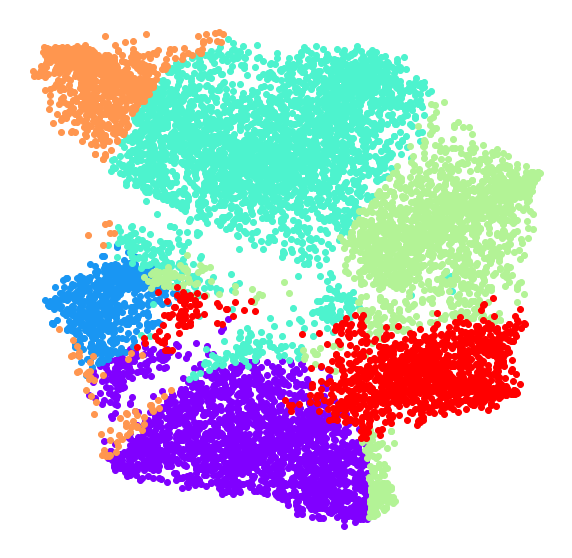

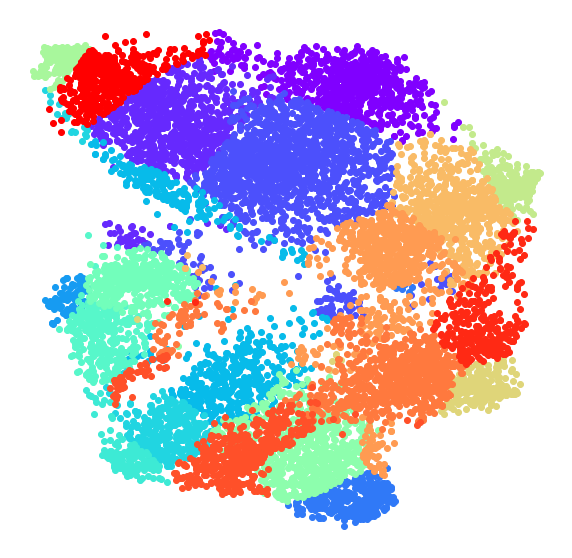

280840


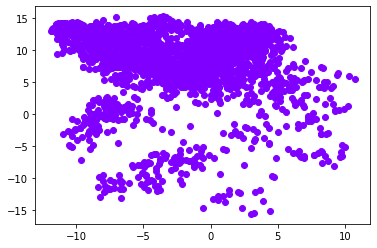

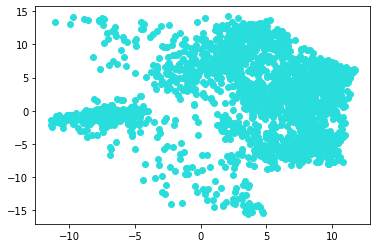

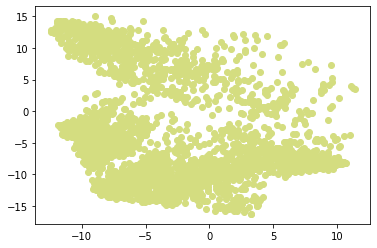

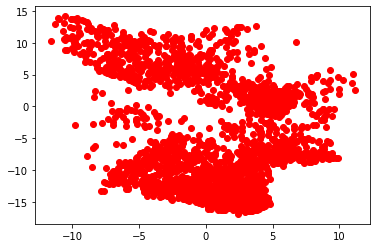

In [ ]:
plot_concept_clusters(clusters_small,t) # clusters and t must be whitened
plot_concept_clusters(clusters_large,t) # clusters and t must be whitened
print(len(predictions))
plot_cancer_clusters(predictions[subset],t)

---
# Concept Completeness

In [12]:
# Activation Graph to Concept Graph


# Attach the hook

activations = []

def save_activation_graph(self, input, output):
    global activations
    activations.append(output)



model.gnn.conv[-1].register_forward_hook(save_activation_graph)



In [13]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_activation_concept_from_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return ag,activation_to_concept_graph(ag,means,k)



In [14]:

from torch_geometric.utils import to_networkx
import networkx as nx
from torch_geometric.data import Data

def vizualize_concept_graph(graph,means,k):
    print(graph.y)
    _,x = predict_activation_concept_from_graph(graph,means,k)
    print((x.sum(dim=0)>(len(x)/10)).sum())
    edge_index  = graph.edge_index
    pos = {i:tuple(graph.pos[i]) for i in range(len(graph.pos))}
    colours = cm.rainbow(np.linspace(0,1,k))
    node_colours = [colours[i] for i in x.argmax(dim=1)]
    
    g = Data(x=x,edge_index=edge_index,pos=pos)
    G = to_networkx(graph,to_undirected=True)

    f,ax = plt.subplots(1,1,figsize=(70,70))
    nx.draw(G,pos=pos,node_color=node_colours,node_size=500)
    plt.show()

tensor([0])
tensor(2)


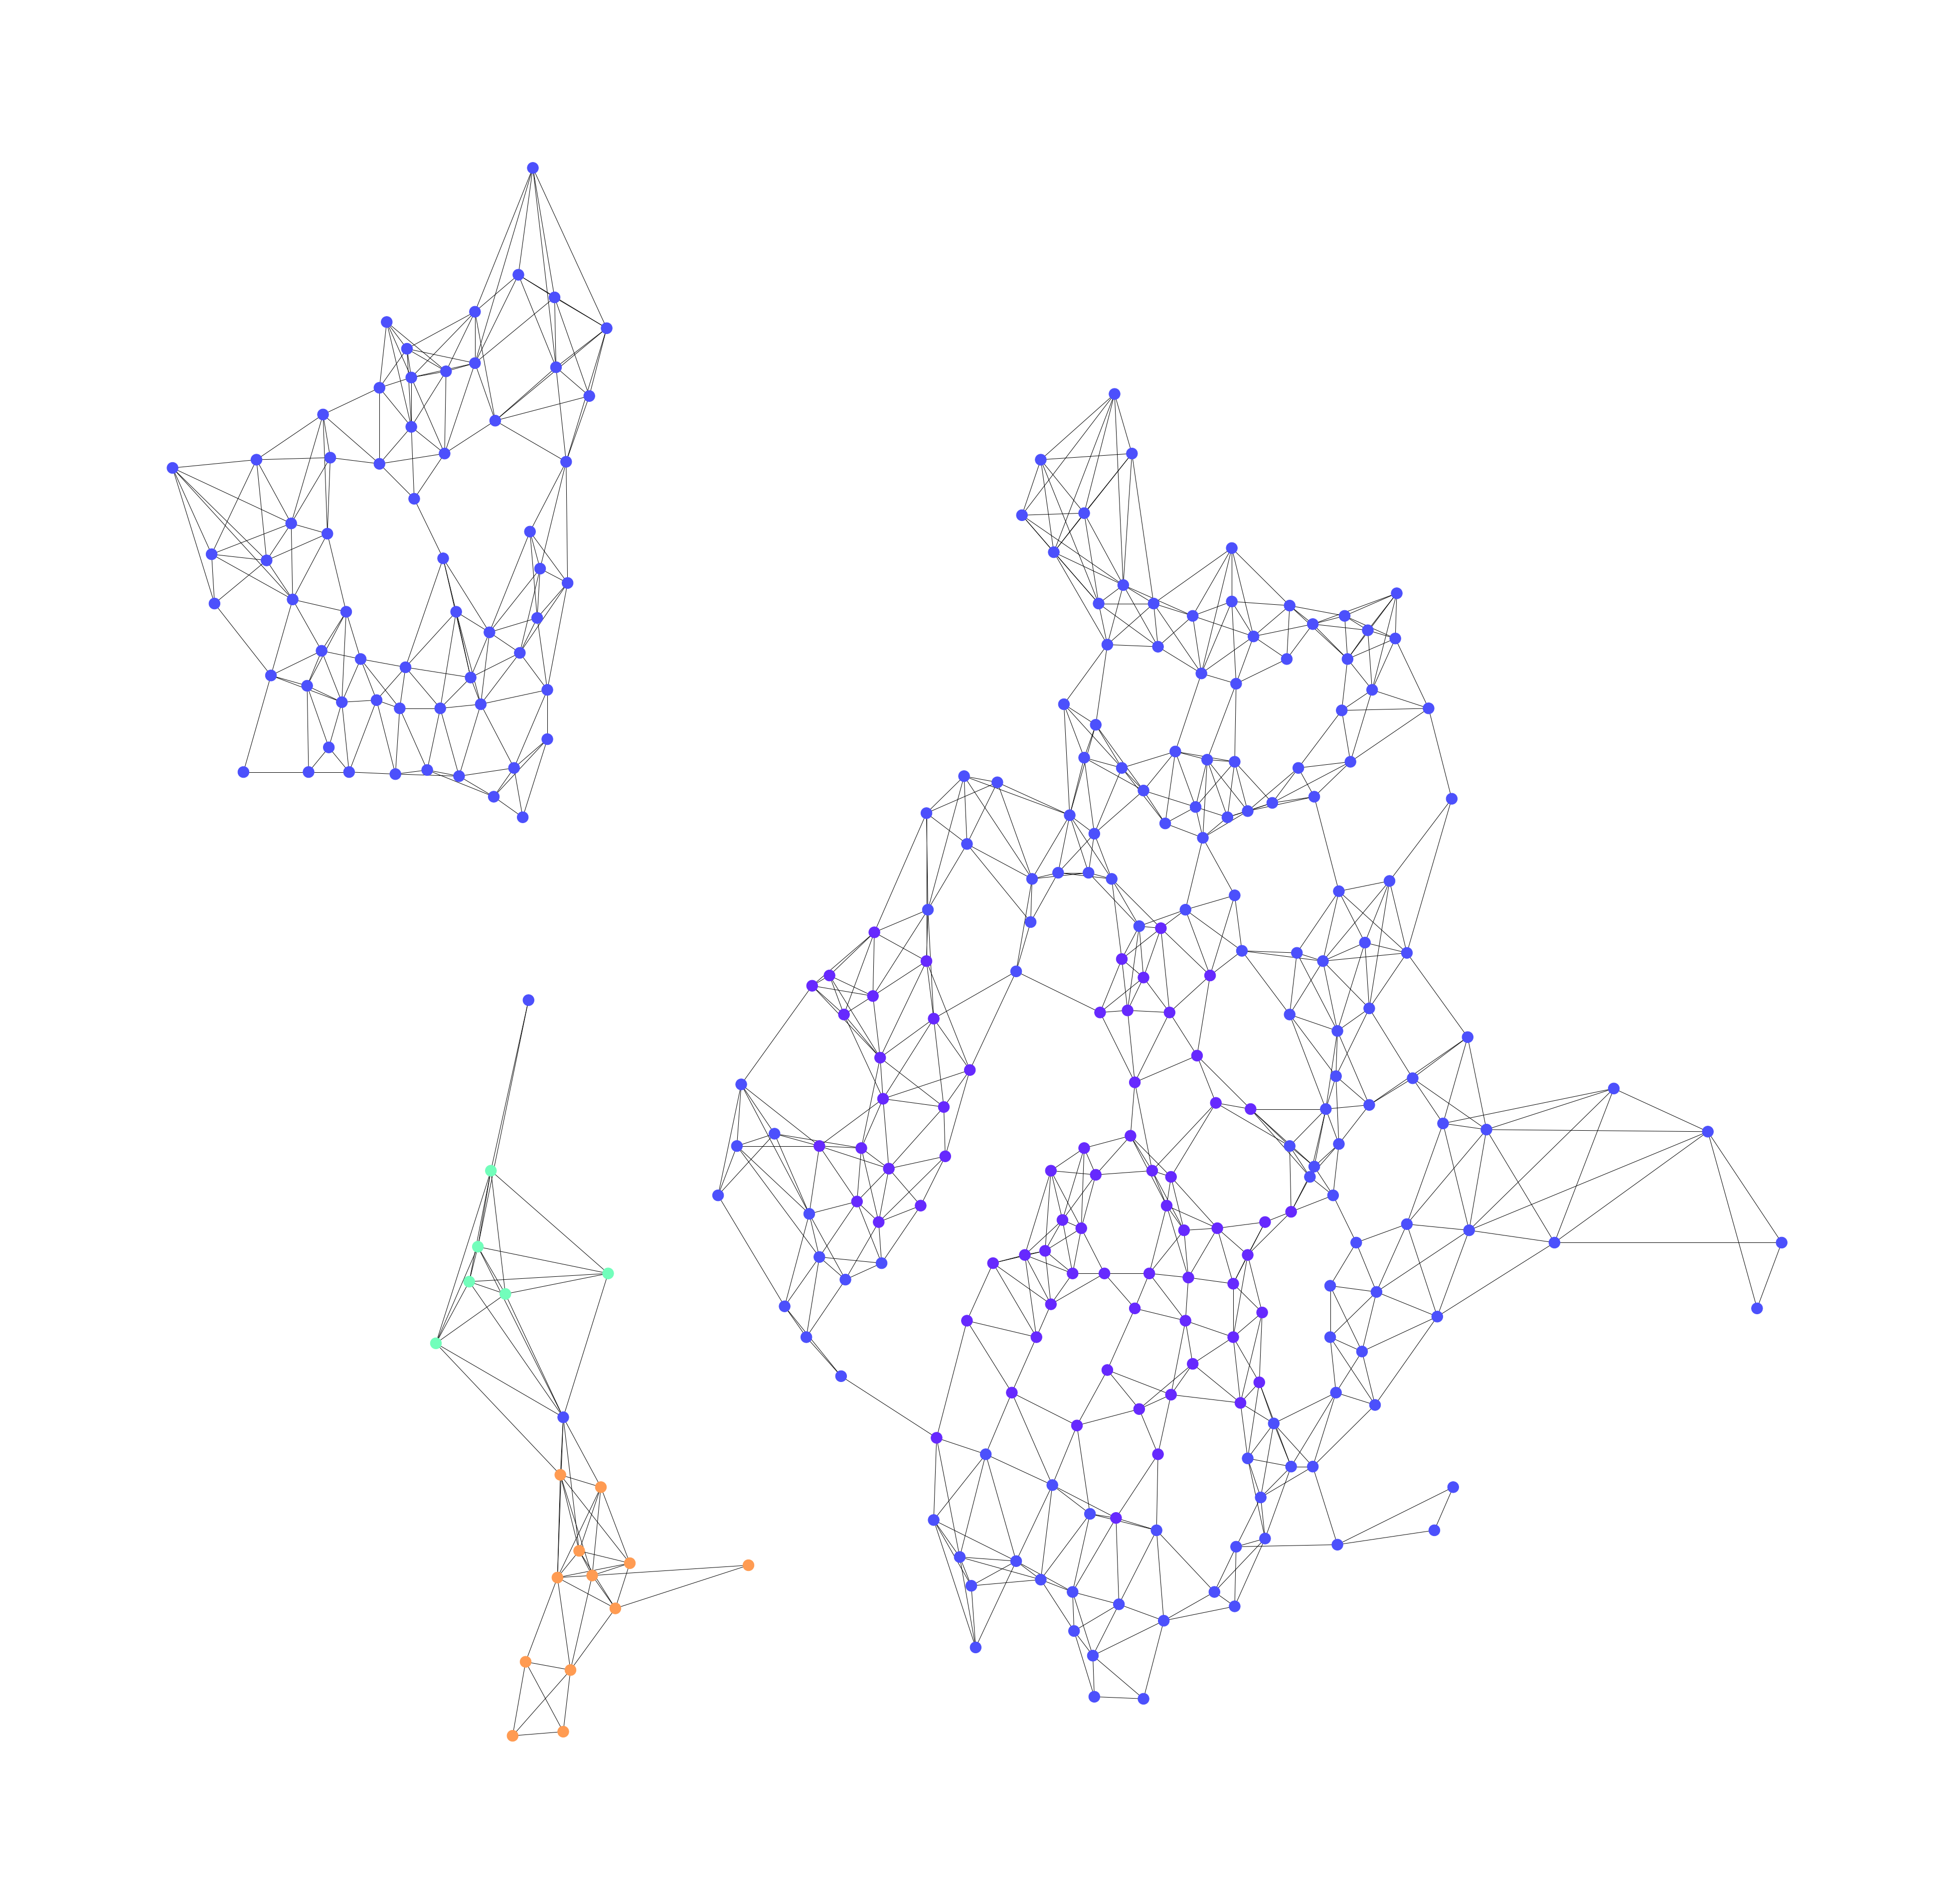

In [ ]:
vizualize_concept_graph(next(iter(train_loader)),means_large,k_large)

---

In [ ]:
def concept_vs_cancer(loader): return [(predict_activation_concept_from_graph(batch,means_large,k_large)[1].mean(dim=0),batch.y) for batch in loader]

In [ ]:
x_train = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(train_loader))))
y_train = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(train_loader))))

x_val = np.array(list(map(lambda x:list(map(lambda y:y.item(),x[0])),concept_vs_cancer(val_loader))))
y_val = np.array(list(map(lambda x:x[1].item(),concept_vs_cancer(val_loader))))

In [ ]:
def plot_agg_concept_for_class(cls,x,y):
    f = plt.figure(figsize=(20,10))
    ind = y==cls
    assert len(x) == len(y)

    plt.imshow(x[ind].reshape(k_large,-1))


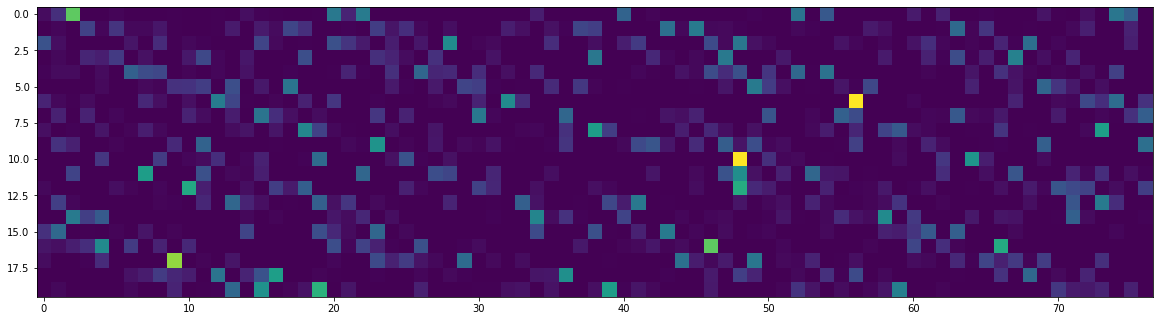

In [ ]:
plot_agg_concept_for_class(1,x_train,y_train)

In [ ]:
torch.as_tensor(x_train).max(dim=0)

torch.return_types.max(
values=tensor([0.7697, 0.5567, 0.9718, 0.8448, 0.7521, 0.5165, 0.6335, 0.4025, 0.6583,
        0.5641, 0.5059, 0.7545, 0.6174, 0.6160, 0.6036, 0.5942, 0.6646, 0.6654,
        1.0000, 0.5975], dtype=torch.float64),
indices=tensor([ 67,   1,   8, 280, 211, 236, 299, 215, 161, 105, 248,  62, 119, 285,
        117, 265, 255, 266,  96,  60]))

In [ ]:
X_train = torch.zeros(0,k_large)
Y_train = torch.zeros(0)

for graph in train_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    _,x = predict_activation_concept_from_graph(graph,means_large,k_large)
    X_train = torch.cat([X_train,x],dim=0)
    Y_train = torch.cat([Y_train,y],dim=0)

NameError: name 'k' is not defined

In [ ]:
len(X_train),len(Y_train),(Y_train==3).sum()

In [ ]:
X_val = torch.zeros(0,k)
Y_val = torch.zeros(0)

for graph in val_loader:
    num_nodes = len(graph.x)
    y = torch.zeros(num_nodes) + graph.y
    _,x = predict_activation_concept_from_graph(graph,means_large,k_large)
    X_val = torch.cat([X_val,x],dim=0)
    Y_val = torch.cat([Y_val,y],dim=0)

In [ ]:
print((Y_val<=1))

---
### CBE

In [ ]:
## Linear Model
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import sklearn.tree as tree


l = tree.DecisionTreeClassifier(criterion="entropy").fit(X_train,Y_train)

tree.plot_tree(l)

print(l.score(X_train,Y_train))
print(l.score(X_val,Y_val))



In [15]:
# See P(class|concept)
from tqdm import tqdm
from torch.nn.functional import normalize


def class_concept_joint_frequency(CLS,CONCEPT,k):
    class_concept = torch.zeros(4,k)
    for cons,cl in tqdm(zip(CONCEPT,CLS)):
        class_concept[cl.int(),cons.argmax()] += 1
    return class_concept
    

In [16]:

def class_condition_concepts_prob(joint_freq,concepts): # concepts in one_hot_form
    output = torch.zeros(4)
    joint_freq+=1
    def _p_class(cl): return joint_freq[cl].sum()/joint_freq.sum()
    def _p_concept(cons): return joint_freq[:,cons].sum()/joint_freq.sum()
    def _p_concept_given_class(cons,cl): return joint_freq[cl,cons]/joint_freq[cl].sum()
    for cl in range(4):
        tot = torch.log(_p_class(cl))
        for cons in concepts:
            cons = cons.argmax()
            tot  += torch.log(_p_concept_given_class(cons,cl))
            tot -= torch.log(_p_concept(cons))
        output[cl] = tot
    return output       
        
    

In [ ]:
freq = class_concept_joint_frequency(Y_train,X_train)
class_condition_concepts_prob(freq,X_train[0:10000])

NameError: name 'Y_train' is not defined

In [ ]:
from torch.nn.functional import normalize

z = normalize(freq,dim=1,p=1)
y = torch.zeros(k,2)
y[:,0] = z[:,0]+z[:,1]
y[:,1] = z[:,2]+z[:,3]
y

NameError: name 'freq' is not defined

In [ ]:
z

NameError: name 'z' is not defined

---
# Deducing K


1) Choose K
2) Get Convert list of graphs to list of (activation, graph id)
3) Get list (graph_id, ground_truth, pred_truth)
4) Generate means and hence concepts from activations
5) Get concepts from activations
6) Use decision tree to predict (concept-> cancer_type)
7) Evaluate how accurate
8) **Define concept prevelance score** and evaluate. If below certain threshold
9) Increment K and plot.

In [17]:
from tqdm import tqdm
import sklearn.tree as tree

def first(x): return x[0]
def second(x): return x[1]
def third(x): return x[2]



def deduce_k(train_loader,val_loader,model,max_k=60,increments=6,start_k=10):
    global activations
    ks = []
    dt_scores = []
    concept_accs = []
    min_concept_prev = []
    max_concept_prev = []
    for k in tqdm(range(start_k,max_k,increments)):
        #1
        act_graph = []
        graph_gt_pred = []
        #2 & 3
        for i,graph in enumerate(train_loader):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            act_graph += [(act, i) for act in activations[0]]
            graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        graph_gt_pred = sorted(graph_gt_pred)
        
        
        val_act_graph = []
        val_graph_gt_pred = []
        #2 & 3
        for i,graph in enumerate(val_loader):
            activations = []
            pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
            val_act_graph += [(act, i) for act in activations[0]]
            val_graph_gt_pred += [(i,graph.y.squeeze(),pred)]
        val_graph_gt_pred = sorted(val_graph_gt_pred)
        
        
        
        
        #4
        
        obs = torch.stack(list(map(lambda x:x[0],act_graph))).numpy()
        obs_white = whiten(obs)
        means,_ = kmeans(obs_white,k_or_guess=k)
        clusters = cluster(obs_white,means,k)
        
        #5
        concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),act_graph)) # DO NOT FORGET TO WHITEN
        concepts_by_graph = [torch.stack([c[0] for c in concepts_graph if c[1]==g]) for g in range(len(graph_gt_pred))]
        
        val_concepts_graph = list(map(lambda p:(activation_to_concept(whiten(p[0].numpy()),means),p[1]),val_act_graph)) # DO NOT FORGET TO WHITEN
        val_concepts_by_graph = [torch.stack([c[0] for c in val_concepts_graph if c[1]==g]) for g in range(len(val_graph_gt_pred))]
        
        #6
        concepts = torch.stack(list(map(first,concepts_graph)))
        classes = torch.as_tensor(list(map(lambda x:graph_gt_pred[x[1]][1].item(),concepts_graph)))
        
        val_concepts = torch.stack(list(map(first,val_concepts_graph)))
        val_classes = torch.as_tensor(list(map(lambda x:val_graph_gt_pred[x[1]][1].item(),val_concepts_graph)))
        
        dt = tree.DecisionTreeClassifier(criterion="entropy").fit(concepts.numpy(),classes.numpy())
        
        
        #6.5
        
        joint_freq = class_concept_joint_frequency(classes,concepts,k)
        val_concept_pred = torch.as_tensor(list(map(lambda i: class_condition_concepts_prob(joint_freq,val_concepts_by_graph[i]).argmax(), range(len(val_graph_gt_pred)))))
        gt = torch.as_tensor(list(map(second,val_graph_gt_pred)))
        pred = torch.as_tensor(list(map(third,val_graph_gt_pred)))
        
        concept_acc = (val_concept_pred==gt).sum()/len(gt)
        
        concept_prevalence = torch.sum(torch.stack(list(map(lambda x: (x.sum(dim=0)>=len(x)/20),concepts_by_graph))),dim=0)
        #7
        ks += [k]
        dt_scores += [dt.score(val_concepts.numpy(),val_classes.numpy())]
        concept_accs += [concept_acc]
        min_concept_prev += [concept_prevalence.min()]
        max_concept_prev += [concept_prevalence.max()]
        
    return ks,dt_scores,concept_accs,min_concept_prev,max_concept_prev
        
#ks,dts,concept_accs,min_concept_prev,max_concept_prev = deduce_k(train_loader,val_loader,model,max_k=35,increments=5,start_k=5)

---
# Concept Discovery

In [18]:
def generate_k_concepts(model,train_loader,k):
    act_graph = []
    graph_gt_pred = []
    #2 & 3
    for i,graph in enumerate(train_loader):
        activations = []
        pred = model(graph.x,graph.edge_index,graph.batch).argmax(dim=1).squeeze()
        act_graph += [(act, i) for act in activations[0]]
        graph_gt_pred += [(i,graph.y.squeeze(),pred)]
    graph_gt_pred = sorted(graph_gt_pred)
    
    
    
    #4
    
    obs = torch.stack(list(map(lambda x:x[0],act_graph))).numpy()
    obs_white = whiten(obs)
    means,_ = kmeans(obs_white,k_or_guess=k)
    return means

---
# Concept Representation

In [130]:
# DISCOVER CONCEPTS

from tqdm import tqdm
from scipy.cluster.vq import kmeans
import numpy as np

raw_activations = torch.zeros(0,32)

k = 80

for batch in tqdm(train_loader):
    model(batch.x,batch.edge_index,batch.batch)

#for batch in val_loader:
#    model(batch.x,batch.edge_index,batch.batch)




obs = raw_activations.detach().numpy()
mu,sigma = obs.mean(axis=0),obs.std(axis=0)

print(len(obs))
def whiten(obs):
    return (obs - mu)/sigma

obs_white = whiten(obs)
means,_ = kmeans(obs_white,k_or_guess=k)



100%|██████████| 308/308 [00:24<00:00, 12.55it/s]


280840


In [131]:
from torch.nn.functional import one_hot

def activation_to_concept(activation,means):
    return one_hot(torch.as_tensor(nearest_mean(activation,means)),len(means))

def activation_to_concept_graph(activations,means,k):
    output = torch.zeros(0,k)
    for i in range(len(activations)):
        concept = activation_to_concept(whiten(activations[i]).numpy(),means).unsqueeze(0)
        output = torch.cat([output,concept],dim=0)
    return output


def predict_activation_concept_from_graph(graph,means,k):
    global activations
    activations = []
    model(graph.x,graph.edge_index,graph.batch)
    ag = activations[0]
    return ag,activation_to_concept_graph(ag,means,k)



In [132]:
# For determining how what sort of cancer diagnosis a concept indicates

X_train = torch.zeros(0,k)
Y_train = torch.zeros(0)

for graph in tqdm(train_loader):
    num_nodes = len(graph.x)

    y = torch.zeros(num_nodes) + graph.y
    _,x = predict_activation_concept_from_graph(graph,means,k)
    X_train = torch.cat([X_train,x],dim=0)
    Y_train = torch.cat([Y_train,y],dim=0)



#class_condition_concepts_prob(freq,X_train[0:10000])

100%|██████████| 308/308 [01:30<00:00,  3.40it/s]


In [133]:
print(len(Y_train[X_train.argmax(dim=1)==2]))
freq = class_concept_joint_frequency(Y_train,X_train,k)

1311


280840it [00:06, 41843.68it/s]


In [134]:
p_class_given_concept = (freq.transpose(1,0)).int() # /freq.reshape(-1,4).sum(dim=1,keepdim=True))*100
print(freq.shape)
p_class_given_concept = ((freq/freq.transpose(1,0).sum(dim=1)).transpose(1,0)*100).int()
print(p_class_given_concept)

torch.Size([4, 80])
tensor([[ 0,  9, 90,  0],
        [ 3, 15, 63, 18],
        [28,  4, 57,  9],
        [ 0,  0, 44, 54],
        [ 0, 14, 60, 25],
        [ 1,  3, 41, 53],
        [50,  0, 45,  3],
        [ 2, 29, 42, 25],
        [42, 33,  9, 14],
        [20, 72,  5,  1],
        [17,  6, 28, 46],
        [ 0,  0, 11, 88],
        [ 6, 70,  5, 17],
        [44,  0, 43, 11],
        [ 8, 59,  4, 28],
        [ 2,  0, 73, 23],
        [ 0,  0,  3, 95],
        [42, 18, 18, 20],
        [ 0, 33, 28, 37],
        [11, 65, 18,  3],
        [ 6, 67, 10, 15],
        [ 7,  1, 34, 55],
        [ 7,  2, 83,  7],
        [ 0,  0, 24, 75],
        [ 3, 86,  5,  4],
        [ 5,  0, 55, 38],
        [ 1, 93,  0,  3],
        [ 1, 23, 39, 34],
        [ 1, 24,  4, 69],
        [21, 55,  5, 16],
        [42, 22, 29,  4],
        [ 8, 62, 10, 18],
        [77,  7,  8,  6],
        [ 5,  5, 27, 61],
        [42,  6, 30, 20],
        [18, 42, 33,  5],
        [11, 38, 49,  1],
        [ 1,  0, 8

In [135]:
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx


def activation_graph_to_concept_graph(graph,means,k):
    output = graph.clone()
    output.activation,output.x = predict_activation_concept_from_graph(graph,means,k)
    return output


def disect_concept_graph(concept_graph,min_subgraph_size=5):
    graph = concept_graph.clone()

    left_nodes,right_nodes = concept_graph.x[graph.edge_index[0,:]].argmax(dim=1),concept_graph.x[graph.edge_index[1,:]].argmax(dim=1)

    keep_edge = left_nodes==right_nodes
    graph.edge_index = graph.edge_index[:,keep_edge]
    
    G = to_networkx(graph, to_undirected=True, node_attrs=['x','activation','pos'])
    
    sub_graphs = [G.subgraph(g) for g in nx.components.connected_components(G) if len(g) >= min_subgraph_size]
    for i,g in enumerate(sub_graphs):
        g = from_networkx(g,group_node_attrs=['activation','x','pos'])
        g.pos = g.x[:,-2:]
        g.activation = g.x[:,:32]
        g.x = g.x[:,32:-2]
        g.graph_id = graph.graph_id
        g.y = graph.y.item()

        g.concept = g.x[0].argmax()
        sub_graphs[i] = g
    return sub_graphs


        
graph = next(iter(train_loader))


cg = activation_graph_to_concept_graph(graph[0],means,k)
print(disect_concept_graph(cg,min_subgraph_size=10))

[Data(edge_index=[2, 712], x=[129, 80], pos=[129, 2], activation=[129, 32], graph_id=[1], y=0, concept=17), Data(edge_index=[2, 142], x=[30, 80], pos=[30, 2], activation=[30, 32], graph_id=[1], y=0, concept=34), Data(edge_index=[2, 80], x=[17, 80], pos=[17, 2], activation=[17, 32], graph_id=[1], y=0, concept=66), Data(edge_index=[2, 48], x=[10, 80], pos=[10, 2], activation=[10, 32], graph_id=[1], y=0, concept=48), Data(edge_index=[2, 296], x=[50, 80], pos=[50, 2], activation=[50, 32], graph_id=[1], y=0, concept=17)]


In [137]:
# GET ALL CANDIDATE EXEMPLARY GRAPHS
exemplary_concept_graphs = [[] for i in range(k)]

for i,graph in tqdm(enumerate(train_loader),total=len(train_loader)):
    sub_graphs = disect_concept_graph(activation_graph_to_concept_graph(graph[0],means,k),min_subgraph_size=20)
    for sg in sub_graphs:
        exemplary_concept_graphs[sg.concept].append(sg)

100%|██████████| 308/308 [01:50<00:00,  2.78it/s]


In [138]:
list(map(len,exemplary_concept_graphs))

[1,
 39,
 11,
 54,
 35,
 24,
 31,
 28,
 137,
 19,
 55,
 4,
 27,
 62,
 60,
 19,
 18,
 166,
 46,
 31,
 14,
 36,
 14,
 30,
 13,
 32,
 30,
 34,
 27,
 45,
 20,
 36,
 51,
 31,
 89,
 30,
 13,
 17,
 5,
 39,
 72,
 26,
 32,
 46,
 20,
 8,
 33,
 22,
 40,
 32,
 9,
 33,
 36,
 32,
 32,
 28,
 32,
 41,
 45,
 14,
 43,
 8,
 43,
 21,
 14,
 24,
 96,
 20,
 49,
 9,
 7,
 78,
 75,
 28,
 9,
 29,
 31,
 41,
 39,
 20]

In [139]:
# FILTER FOR 3 most Interesting

def sieve_graph_id(li):
    output = []
    for i,(score,g) in enumerate(li):
        unique = True
        for j,g2 in enumerate(output):
            if g.graph_id == g2.graph_id:
                unique = False
                break
        if unique:
            output.append(g)
    return output



exemplary_concept_graphs_final = list(exemplary_concept_graphs)
print(len(exemplary_concept_graphs_final))

def score_subgraph(sg,mean):
    dists = ((sg.activation - mean)**2).sum(dim=1)
    assert len(dists)==len(sg.activation)
    return dists.mean()

for cons in tqdm(range(k)):
    
    only_supporting_graphs = list(filter(lambda g: g.y== p_class_given_concept[cons].argmax(),exemplary_concept_graphs[cons]))
    if len(only_supporting_graphs)==0:
        print(cons,p_class_given_concept[cons].argmax(),list(map(lambda x: x.y, exemplary_concept_graphs[cons])))
    best_examples = sieve_graph_id(sorted(map(lambda x:(score_subgraph(x,means[cons]),x),only_supporting_graphs),key=lambda x:x[0]))
    
    best_examples = best_examples[:min(5,len(best_examples))] 
    exemplary_concept_graphs_final[cons] = best_examples
    


80


100%|██████████| 80/80 [00:00<00:00, 282.69it/s]


In [140]:
print(list(map(len,exemplary_concept_graphs_final)))

[1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 4, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 3, 5, 5, 5, 5, 5]


In [141]:

bach_source=  os.path.join(parent, 'data', 'processed', 'BACH_TRAIN')
def visualise_bach_subgraph(sg,crop=True,save=False,save_loc=None):

    img_id = sg.graph_id
    b = BACH(bach_source)
    b.ids= list(range(1,401))
    img_path = b.original_image_paths[img_id-1]
    visualise_concept_subgraph(sg,img_path,means,crop=crop,save=save,save_loc=save_loc)

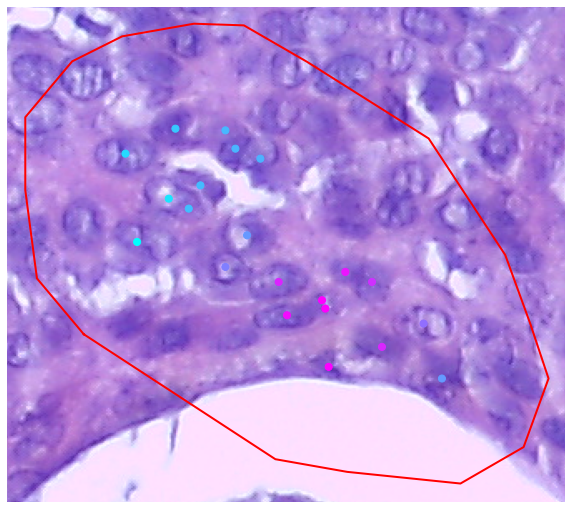

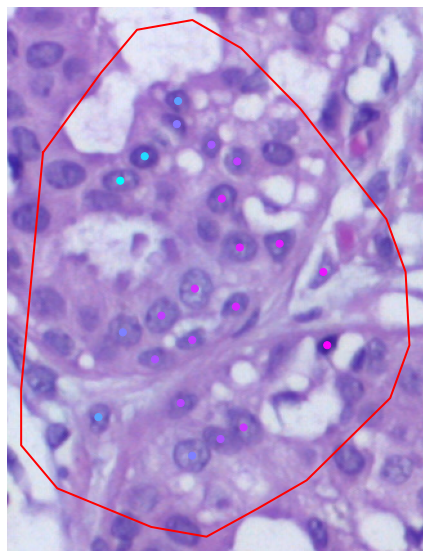

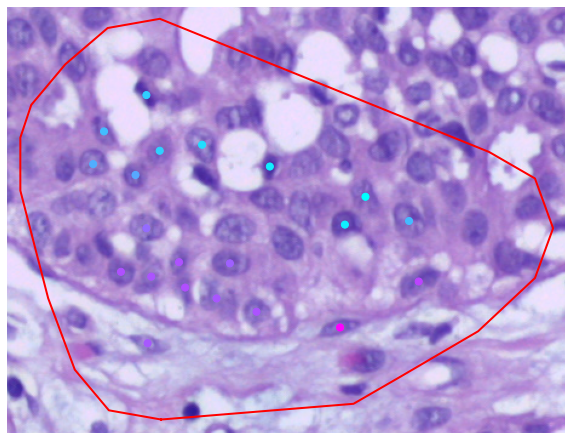

In [142]:
from src.datasets.BACH import BACH, _id_to_path
from PIL import Image
from scipy.spatial import ConvexHull
from src.transforms.graph_construction.hovernet_post_processing import cut_img_from_tile
from torchvision.transforms import ToTensor
from src.utilities.img_utilities import tensor_to_numpy

import matplotlib.pyplot as plt
from matplotlib import cm


def create_point_sphere(centre:torch.Tensor,radius,n_points):
    output = []
    for theta in np.linspace(0,2*np.pi,n_points):

        output += [centre + radius*torch.as_tensor([torch.cos(torch.as_tensor(theta)),torch.sin(torch.as_tensor(theta))])]
    return torch.stack(output)

def visualise_concept_subgraph(sg,image_loc,concept_means,crop=True,save=False,save_loc=None):
    # Load the image
    img = tensor_to_numpy(cut_img_from_tile(ToTensor()(Image.open(image_loc)),tile_size=128))
    # Place nodes on the image
    # Place smoothing sphere around cells
    # Convex hull around
    points = torch.zeros(0,2)
    centres = []
    distances = ((sg.activation - concept_means[sg.concept])**2).sum(dim=1)
    height = []
    for i in range(len(sg.x)):
        centre = sg.pos[i]
        centres.append(centre)
        height.append(distances[i])
        cell_points = create_point_sphere(centre,64,10)
        points = torch.cat([points,cell_points])
    points = points[ConvexHull(points.numpy()).vertices]
    points = torch.cat([points,points[0].unsqueeze(0)])
    centres = torch.stack(centres)
    height = torch.stack(height)
    height = (height-height.min())/(height.max()-height.min())
    colours = cm.cool(height)
    
    f = plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.plot(points[:,0].numpy(),points[:,1].numpy(),'r-',lw=2)
    plt.scatter(centres[:,0].numpy(),centres[:,1].numpy(),c =colours,s=50)
    if(crop):
        padding = 10
        xmin = int(max((points[:,0].numpy()-padding).min(),0))
        xmax = int(min((points[:,0].numpy()+padding).max(),img.shape[1]))
        ymin = int(max((points[:,1].numpy()-padding).min(),0))
        y_max = int(min((points[:,1].numpy()+padding).max(),img.shape[0]))
        plt.xlim(xmin,xmax)
        plt.ylim(ymin,y_max)

    plt.imshow(img)
    
    if(save and save_loc is not None):
        plt.savefig(save_loc)
        plt.close(f)



    # Convert convex hull shape to shape object PIL
    # Fill shape and use as mask to place over image.
    # Colour border by concept number
    
i = 19
for j in range(3):
    visualise_bach_subgraph(exemplary_concept_graphs_final[i][j],crop = True)

In [143]:
from src.utilities.os_utilities import create_dir_if_not_exist
def save_discovered_concepts(folder_location,concept_means,exemplary_concept_graphs_final):
    create_dir_if_not_exist(folder_location,file_path=False)
    np.save(os.path.join(folder_location,'concept_means.npy'),concept_means)
    for cons in range(len(concept_means)):
        for i,cons_example in enumerate(exemplary_concept_graphs_final[cons]):
            visualise_bach_subgraph(cons_example,crop=True,save=True,save_loc=os.path.join(folder_location,'c'+str(cons)+'e'+str(i)+'.png'))

In [144]:
save_discovered_concepts(os.path.join(parent, 'data', 'processed', 'CONCEPTS'),means,exemplary_concept_graphs_final)

C:\Users\aless\AppData\Local\Temp\ipykernel_23344\341091823.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f = plt.figure(figsize=(10,10))


### Good ones
60

--- 
# Explaining Prediction

In [ ]:
# TODO EXTEND TO LIST OF SUBGRAPHS